In [38]:
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch.nn.functional as F
import numpy as np
from ConvWass2D import ConvolutionalWasserstein2D
import torchvision
from torchvision import transforms
from utils import d, make_K_slow, make_K, multiply_reshape

In [39]:
def show_image(inp, ax=None):
    inp = inp / torch.max(inp.view(3, -1), dim=-1).values.view(3, 1, 1)
    inp = torchvision.transforms.ToPILImage()(inp)
    if ax is None:
        plt.imshow(inp) #[0,...])
        plt.show()
    else:
        ax.imshow(inp)


In [40]:
def transform(inp):
    main_transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor()],
    )
    inp = main_transform(inp)
    inp = inp + 1e-4
    inp = inp / torch.sum(torch.abs(inp))
    return inp

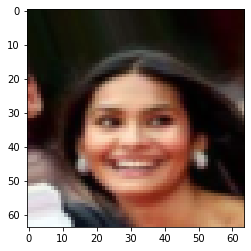

In [41]:
ds = torchvision.datasets.CelebA("/mnt/home/hlawrence/ceph/datasets/celeba", split='train', transform=transform, target_type="landmarks")
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
for x, y in dl:
    break
show_image(x[0])

In [70]:
landmark = y[0]
landmarks_labels = ["left eye", "right eye", "nose", "left mouth", "right mouth"]
numim = 2
numdim = 2
keypoints = torch.zeros(len(landmarks_labels), numim, numdim)
H = 218
W = 178
out_size = 64
landmark_mask = torch.zeros(len(landmarks_labels), out_size, out_size)
for i, idx in enumerate(np.arange(0, len(landmarks_labels)*2, 2)):
    x_coord, y_coord = landmark[idx+1], landmark[idx]
    
    x_coord = torch.round(x_coord/H*out_size).int().item()
    y_coord = torch.round(y_coord/W*out_size).int().item()
    keypoints[i, 0, :] = torch.tensor([x_coord, y_coord])
    landmark_mask[i, x_coord, y_coord] = 1
keypoints = keypoints.long()

In [72]:
def get_img_landmarks(y, H=218, W=178, out_size=64):
    numim = y.shape[0]
    numdim = 2
    keypoints = torch.zeros(len(landmarks_labels), numim, numdim)
    lminds = np.arange(0, len(landmarks_labels)*2, 2)
    for i, idx in enumerate(lminds):
        keypoints[i, :, 0] = torch.round(y[:, idx+1]/H*out_size) #.int() #.item() # y[:, idx+1]
        keypoints[i, :, 1] = torch.round(y[:, idx]/H*out_size) #.int() #y[:, idx]
    return keypoints.long()
    

In [56]:
x.shape

torch.Size([32, 3, 64, 64])

In [62]:
keypoints = get_img_landmarks(y)

In [51]:
keypoints.long().dtype

torch.int64

In [63]:
keypoints[0,:,:]

tensor([[33, 20],
        [33, 21],
        [32, 20],
        [33, 20],
        [32, 20],
        [33, 20],
        [33, 21],
        [33, 23],
        [33, 20],
        [33, 20],
        [33, 20],
        [32, 21],
        [33, 20],
        [33, 21],
        [33, 20],
        [33, 20],
        [33, 20],
        [33, 20],
        [32, 22],
        [32, 21],
        [33, 21],
        [33, 20],
        [33, 20],
        [32, 21],
        [32, 21],
        [32, 21],
        [33, 20],
        [33, 20],
        [33, 20],
        [33, 20],
        [33, 21],
        [32, 21]])

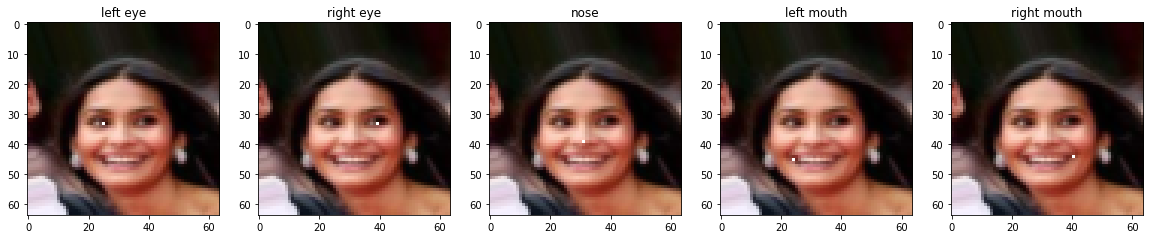

In [73]:
img = x[0]
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
base_color = torch.max(img.view(3, -1), dim=-1)[0][0]
for i in range(5):
    img = x[0].clone()
    img[:, keypoints[i, 0, 0], keypoints[i, 0, 1]] = base_color
    #img[:, landmark_mask[i] > 0] = base_color
    show_image(img, ax[i])
    ax[i].set_title(landmarks_labels[i])
plt.show()

In [ ]:
for b in range(32):
    print(b)
    show_image(x[b])

In [ ]:
# example conv_was
for start_idx, target_idx in [(6,4), (21, 24)]:
    cw = ConvolutionalWasserstein2D(3, 64, gamma=1)
    pos_alphas = torch.arange(0.25, 1, 0.15)
    fig, ax = plt.subplots(1, len(pos_alphas)+2, figsize=((len(pos_alphas)+2)*3, 3))
    inp = x[[start_idx, target_idx]]
    show_image(inp[1,...], ax[0])
    ax[0].set_title(f"Start")
    show_image(inp[0, ...], ax[-1])
    ax[-1].set_title(f"End")

    with torch.no_grad():
        for i, alpha in enumerate(pos_alphas):
            alphas = torch.tensor([alpha, 1-alpha])
            fac = 0.3
            out = cw.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
            show_image(out, ax[i+1])
            ax[i+1].set_title(f"Alpha {alpha:.2}")
    plt.show()

In [ ]:
f"{0.50332490:.4}"

In [ ]:
cw = ConvolutionalWasserstein2D(3, 64, gamma=1)

In [ ]:
w, v = cw.sinkhorn(x[[0]], x[[1]], 10, return_wv=True)

In [ ]:
v.shape

In [ ]:
plan = v*cw.H(w)

In [ ]:
v.shape

In [ ]:
plan